In [20]:
import os
import glob
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
import random
import boto3
import botocore
%matplotlib inline

### configure your aws credentials to get write access on S3
https://docs.aws.amazon.com/de_de/cli/latest/userguide/installing.html

In [21]:
home = os.getcwd().split('AUT-CNN-TUB')[0]

# image centering

In [22]:
def get_all_images_from_part(read_path, partname, extension):

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
    pats_path = [x.string for x in numbers if x is not None]

    if pats_path == []:
        print('ERROR: no directories in path or wrong naming')
        SystemExit
        
    if partname not in pats_path:
        if type(partname) is str:
            print("ERROR: directory for this partnumber doesn't exist" )
            SystemExit
        else:
            partname = str(partname)
            
            if partname not in pats_path:
                print("ERROR: directory for this partnumber doesn't exist")
                SystemExit
                
    if extension  not in ['gif', 'jpeg', 'jpg', 'png', 'JPG']:
        print('ERROR: unknown extension, ', extension)
        SystemExit
        
    else:
        data_path = os.path.join(os.path.join(read_path, partname), '*{}'.format(extension))
        files = glob.glob(data_path)
        return files

In [25]:
#read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry/')
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_canon/')

In [26]:
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
[x.string for x in numbers if x is not None]

['2',
 '13',
 '14',
 '1',
 '7.1',
 '8',
 '5',
 '4',
 '3',
 '10',
 '12',
 '11',
 '6',
 '7.2',
 '15',
 '9']

In [27]:
files = get_all_images_from_part(read_path, 1, 'JPG')# 'jpg', 'JPG'

In [31]:
# get filenumber by filename
for z,i in enumerate(files):
    if '07.2.0.1.0421' in i:
        print(i, z)

In [32]:
file_path = files[9]
img_name = file_path.split('/')[-1]  
image = cv2.imread(file_path)

### original

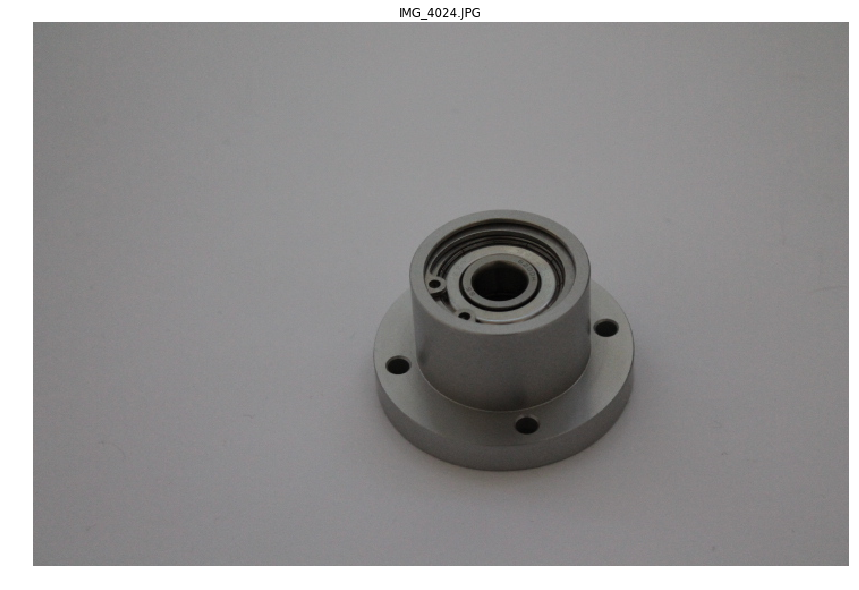

In [33]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### grayscale

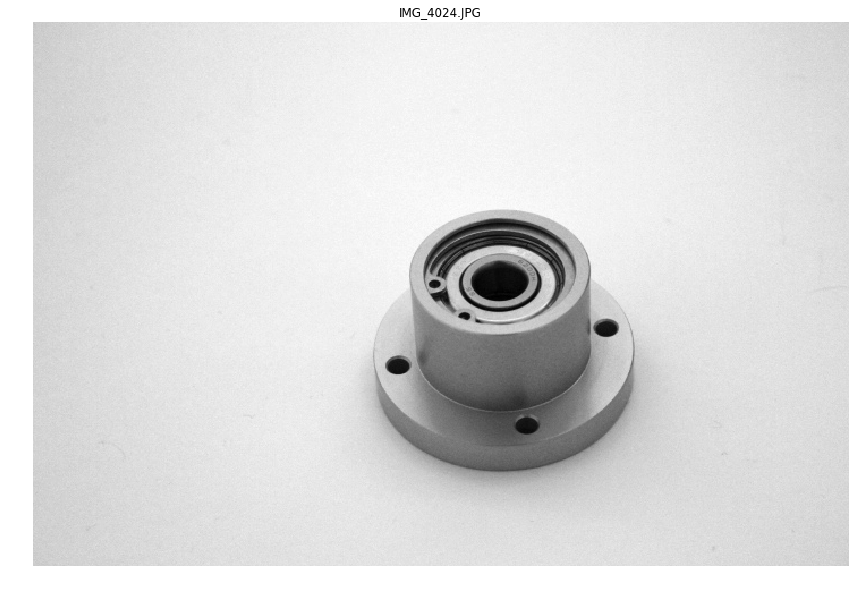

In [34]:
imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(imgray, cmap='gray');
plt.show()

In [35]:
# set factors
form_factor = imgray.shape[1]/1280
brightness = imgray.mean()

### blurred

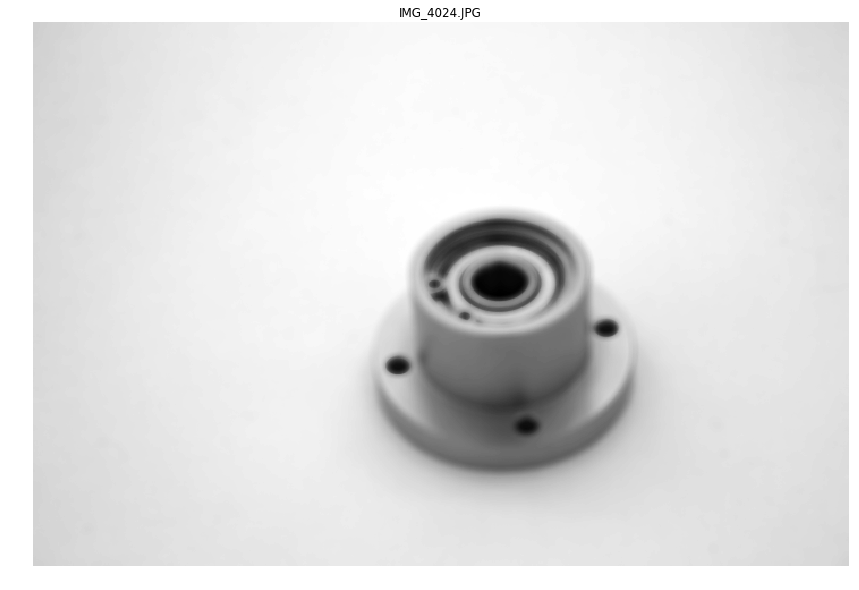

In [36]:
blurred = cv2.bilateralFilter(imgray,10, 50 / form_factor, 50 / form_factor)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(blurred,  cmap='gray')
plt.show()

# edge detection

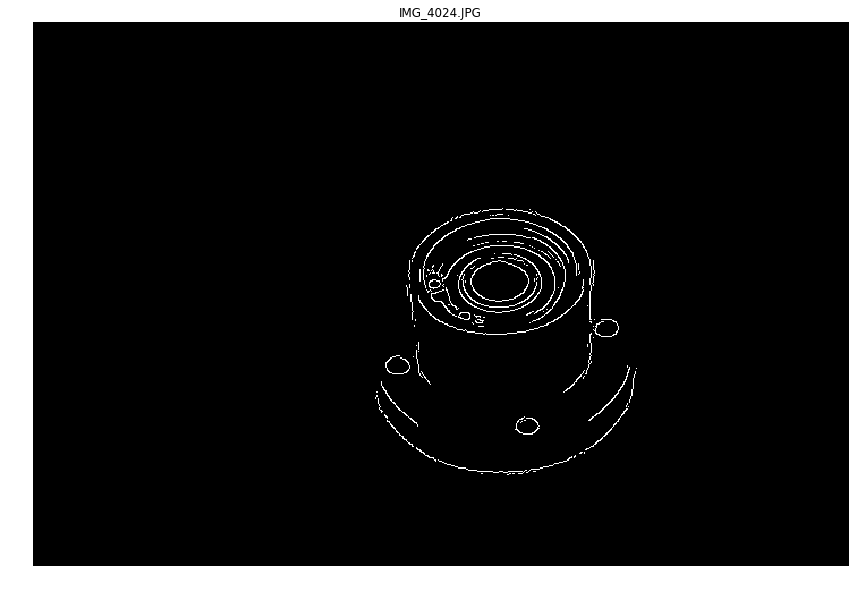

In [39]:
thresh = cv2.Canny(blurred, brightness/4 , brightness/4 )

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(thresh, cmap='gray');
plt.show()

# dilation

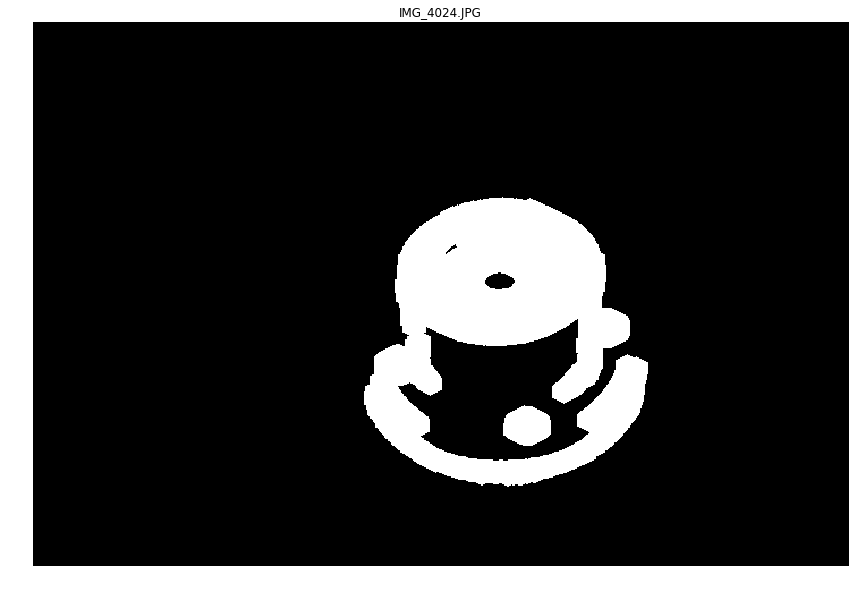

In [40]:
kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
dilation = cv2.dilate(thresh,kernel,iterations = 5)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(dilation, cmap='gray');
plt.show()

# get max contourArea

In [44]:
c = max(contours, key = cv2.contourArea)

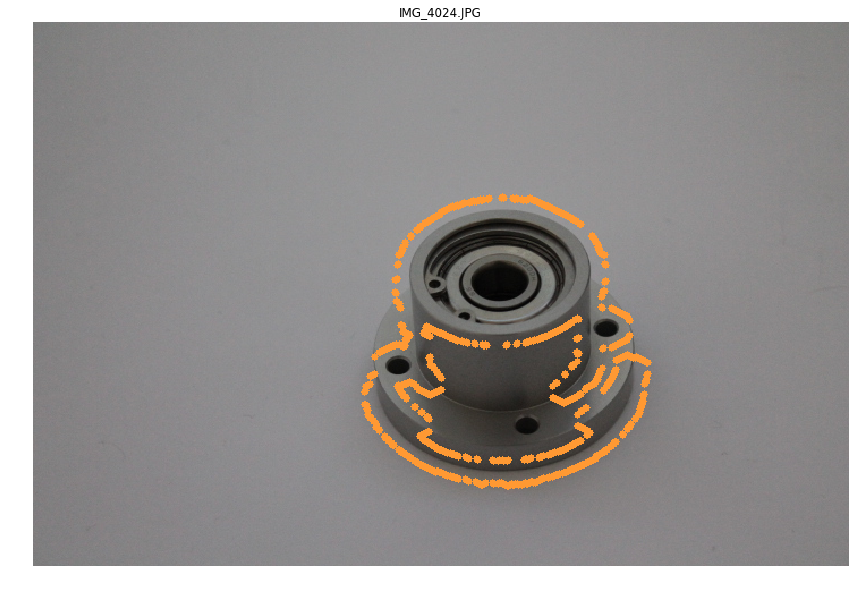

In [52]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.drawContours(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), c, -3, (255, 153, 51), 5));
plt.show()

### fit in circle, to know where to cut

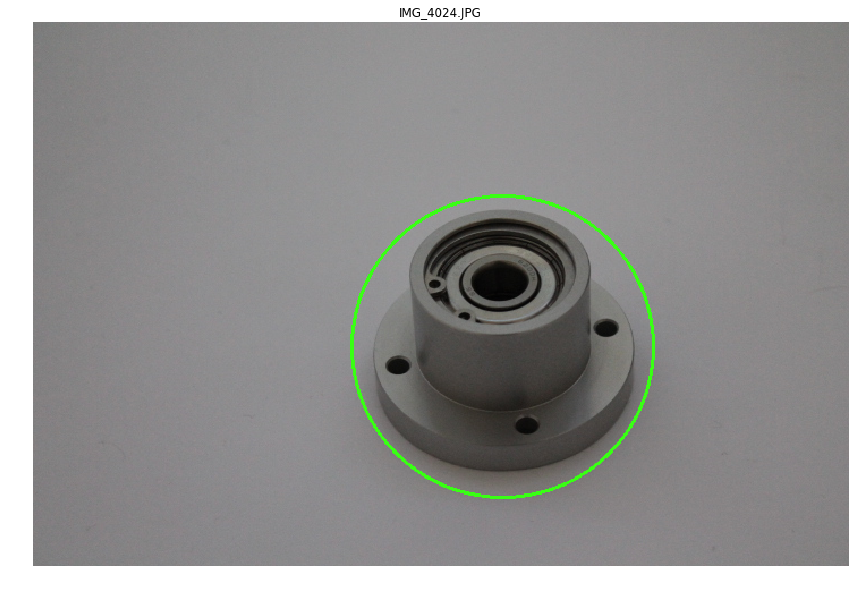

In [53]:
(x,y),radius = cv2.minEnclosingCircle(c)
center = (int(x),int(y))
radius = int(radius)
img = cv2.circle(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
                 center,
                 radius,
                 (57, 255,20),2)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img)
plt.show()

# cutted and scaled image

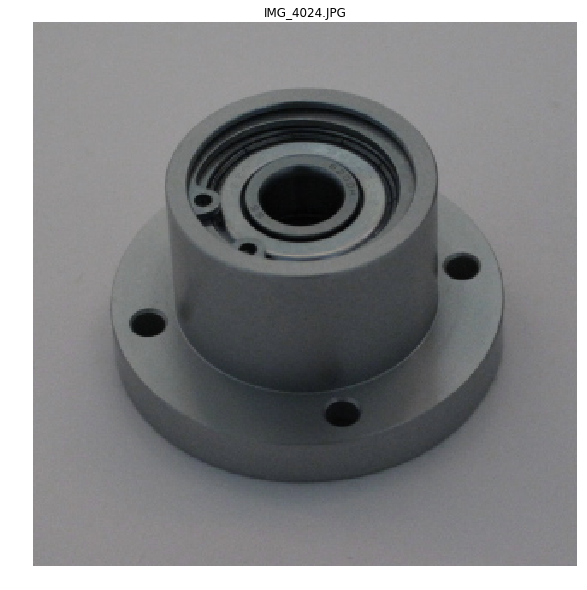

In [54]:
scale = 1.2
scaled_rad = int(radius * scale)
try:
    img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                       center[0] - scaled_rad : center[0] + scaled_rad,
                       : ] 
except:
    img_cutted = image[center[1] - radius : center[1] + radius,
                       center[0] - radius : center[0] + radius,
                       : ] 
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img_cutted)
plt.show()

# get variance of the cutted image 

In [30]:
img_cutted.var()

1439.4397119022797

# function summing up all steps explained above

In [48]:
def get_part_from_image(image, scale = 1.1):
    
    imgray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    brightness = imgray.mean()
    form_factor = imgray.shape[1]/1280

    blurred = cv2.bilateralFilter(imgray, 10, brightness / form_factor, brightness / form_factor)
    thresh = cv2.Canny(blurred, brightness / 4 , brightness / 4 )
    
    kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilation = cv2.dilate(thresh,kernel,iterations = 5)
    
    _,contours,_ = cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key = cv2.contourArea)

    (x,y),radius = cv2.minEnclosingCircle(c)
    center = (int(x),int(y))
    radius = int(radius)

    scaled_rad = int(radius * scale)
    try:
        img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                           center[0] - scaled_rad : center[0] + scaled_rad,
                           : ] 
    except:
        img_cutted = image[center[1] - radius : center[1] + radius,
                           center[0] - radius : center[0] + radius,
                           : ] 

    return img_cutted


# test it 

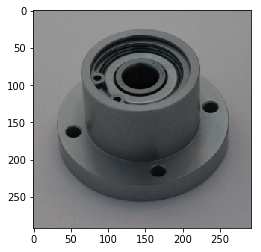

In [49]:
plt.imshow(get_part_from_image(image, scale = 1.1))
plt.show()

0 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4011.JPG
1305.303185202876


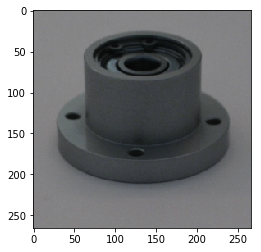

1 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3556.JPG
1394.1555484821456


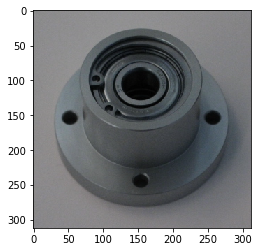

2 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3527.JPG
1372.9325900265153


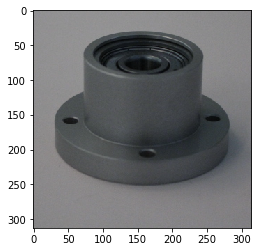

3 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3595.JPG
1742.6997525274612


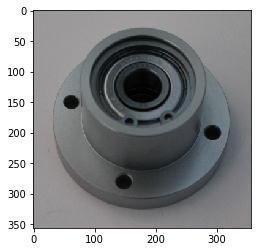

4 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3962.JPG
1458.2942469591437


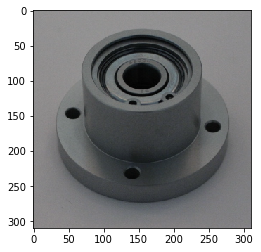

5 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3996.JPG
1203.0114171566652


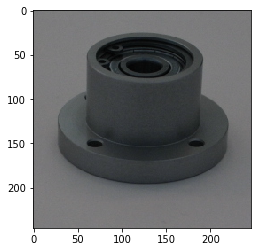

6 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4040.JPG
1371.1241553974505


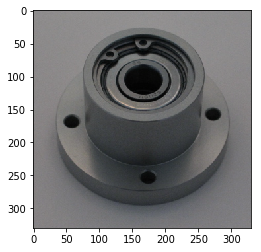

7 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4006.JPG
1223.2027295454413


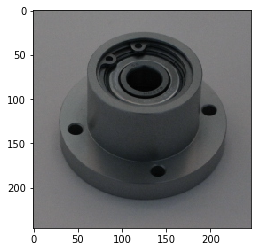

8 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_3956.JPG
1434.414530602779


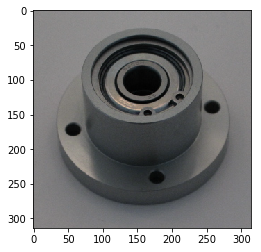

9 /home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_canon/1/IMG_4024.JPG
1523.2745288840154


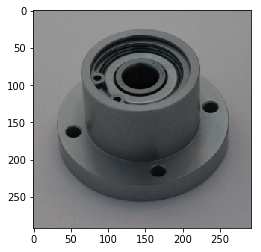

In [51]:
files = get_all_images_from_part(read_path, 1, 'JPG') #jpg
for i, file_path in enumerate(files[:10]):
    image = cv2.imread(file_path)
    print(i,file_path)
    try:
        plt.imshow(get_part_from_image(image, scale = 1.1))
        print(get_part_from_image(image, scale = 1.1).var())
        plt.show()
    except:
        print('ERROR: ', file_path)

## generate folder with centered and well shaped images

In [19]:
new_size = int(28 * 8)
for camera in ['canon','industry']:

    home = os.getcwd().split('AUT-CNN-TUB')[0]
    read_path = os.path.join(home,'AUT-CNN-TUB/Raw_Data_27072018_{}/'.format(camera))
    write_path = os.path.join(home,
                              'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_{}/'.format(camera,new_size))
 
    extension = 'jpg'

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])

    for part_nr in [x.string for x in numbers if x is not None]:
        for file_path in get_all_images_from_part(read_path, part_nr, extension):
            img_name = file_path.split('/')[-1].replace('.jpg','')
            image = cv2.imread(file_path)

            img_centerd = get_part_from_image(image,scale = 1.5)
            if img_centerd is not None:
                try:
                    img_resized = cv2.resize(img_centerd,(new_size, new_size))
                except:
                    print('Image {}.jpg is to small.'.format(img_name))
                    img_resized = None

                part_patch =os.path.join(write_path, part_nr)

                if img_resized is not None:
                    if img_resized.var() > 200:
                        if os.path.exists(part_patch):
                            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                        else:
                            os.makedirs(part_patch)
                            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                    else:
                        print('Image {}.jpg does not have the necessary variance.'.format(img_name))


Image 02.0.2.3.4133.jpg does not have the necessary variance.
Image 02.0.2.3.4149.jpg does not have the necessary variance.
Image 02.0.2.3.4142.jpg does not have the necessary variance.
Image 02.0.2.3.4118.jpg does not have the necessary variance.
Image 02.0.2.3.4127.jpg does not have the necessary variance.
Image 02.0.2.3.4143.jpg does not have the necessary variance.
Image 02.0.2.3.4129.jpg does not have the necessary variance.
Image 02.0.2.3.4148.jpg does not have the necessary variance.
Image 02.0.2.3.4131.jpg does not have the necessary variance.
Image 02.0.2.3.4132.jpg does not have the necessary variance.
Image 02.0.2.3.4146.jpg does not have the necessary variance.
Image 02.0.2.3.4125.jpg does not have the necessary variance.
Image 02.0.2.3.4145.jpg does not have the necessary variance.
Image 02.0.2.3.4119.jpg does not have the necessary variance.
Image 02.0.2.3.4126.jpg does not have the necessary variance.
Image 02.0.2.3.4160.jpg is to small.
Image 02.0.2.3.4152.jpg does not 

Image 05.0.2.3.4344.jpg does not have the necessary variance.
Image 05.0.2.3.4321.jpg does not have the necessary variance.
Image 05.0.2.3.3021.jpg does not have the necessary variance.
Image 05.0.2.3.2996.jpg does not have the necessary variance.
Image 05.0.2.3.2948.jpg is to small.
Image 05.0.2.3.3011.jpg is to small.
Image 05.0.2.3.2975.jpg does not have the necessary variance.
Image 05.0.2.3.3018.jpg does not have the necessary variance.
Image 05.0.2.3.2973.jpg does not have the necessary variance.
Image 05.0.2.3.2999.jpg is to small.
Image 05.0.2.3.3000.jpg is to small.
Image 04.0.2.3.4289.jpg is to small.
Image 04.0.2.3.3753.jpg is to small.
Image 04.0.2.3.4269.jpg is to small.
Image 04.0.2.3.4254.jpg is to small.
Image 04.0.2.3.4272.jpg is to small.
Image 04.0.2.3.4270.jpg is to small.
Image 04.0.2.3.3782.jpg is to small.
Image 04.0.2.3.4268.jpg is to small.
Image 04.0.2.3.4313.jpg is to small.
Image 03.0.2.3.3687.jpg is to small.
Image 03.0.2.3.4203.jpg is to small.
Image 03.0.

### downscale

In [37]:
new_size = int(28 * 4)
for camera in ['industry', 'canon' ]:

    home = os.getcwd().split('AUT-CNN-TUB')[0]
    read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_112x112/'.format(camera))
    write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_{}_centered_{}/'.format(camera, new_size))

    extension = 'jpg'

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
    for part_nr in [x.string for x in numbers if x is not None]:
        for file_path in get_all_images_from_part(read_path, part_nr, extension):
            img_name = file_path.split('/')[-1].replace('.jpg','')
            image = cv2.imread(file_path)

            try:
                img_resized = cv2.resize(image,(new_size, new_size))
            except:
                print('Image {}.jpg is to small.'.format(img_name))

            part_patch =os.path.join(write_path, part_nr)

            if os.path.exists(part_patch):
                cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
            else:
                os.makedirs(part_patch)
                cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

### downscale manually cleaned images


In [58]:
new_size = int(224 / 8)

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_final_224_cleaned/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_final_{}_cleaned/'.format(new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].replace('.jpg','')
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

# overview table

In [59]:
read_path = os.path.join(home,'/home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_final_224_cleaned/')
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(len(os.listdir(os.path.join(read_path, part_nr))), part_nr))


Images in File:
2451	2
2259	13
2540	14
2834	1
2517	7.1
2987	8
2526	5
2102	4
2422	3
2413	10
2324	12
2490	11
1004	6
2305	7.2
2630	15
2253	9


## preprocessing loss


In [61]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/Raw_Data_27072018_industry/')
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])

read_path1 = os.path.join(home,'/home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_industry_centered_28/')
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(((len(os.listdir(os.path.join(read_path, part_nr)))-len(os.listdir(os.path.join(read_path1, part_nr))))/len(os.listdir(os.path.join(read_path, part_nr)))), part_nr))


Images in File:
0.0036463081130355514	2
0.035348837209302326	13
0.0	14
0.0	1
0.009267840593141797	7.1
0.0007861635220125787	8
0.0	5
0.0	4
0.0	3
0.0	10
0.0	12
0.0	11
0.004807692307692308	6
0.0	7.2
0.010387157695939566	15
0.00949367088607595	9


##  split data set into train, validation and test

In [65]:
size =  int(28 * 8)

read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_final_{}_cleaned'.format(size))
path_length   = len(read_path) 

test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned/test/'.format(size))
validate_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned/validate/'.format(size))
train_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned/train/'.format(size))

ratio = 0.7 #train
# test = 0.2
# validate = 0.1
img_path = read_path
GRBtoGray = False
extension = 'jpg'


numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    
    files = get_all_images_from_part(read_path, part_nr, extension)            
    num_imag = len(files)
    Data = np.arange(0, num_imag)            
    random.shuffle(Data)  
    DataTrain = Data[:int(np.round(ratio * num_imag))]              
    DataTest = Data[int(np.round(ratio * num_imag)) : int(np.round(0.9 * num_imag))]         
    DataVal  = Data[int(np.round(0.9 * num_imag)) : ]         
    
    if os.path.exists(test_path) is False:
        os.makedirs(test_path)
        
    if os.path.exists(validate_path) is False:
        os.makedirs(validate_path)
        
    if os.path.exists(train_path) is False:
        os.makedirs(train_path)
    
    for i,f1 in enumerate(files):
        img_name = f1.split('/')[-1]        

        img = cv2.imread(f1)
        if(GRBtoGray == True):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      


        if(i in DataTrain):
            cv2.imwrite(train_path + img_name, img)  
        if(i in DataTest):
            cv2.imwrite(test_path + img_name, img) 
        if(i in DataVal):
            cv2.imwrite(validate_path + img_name, img)  

# save tar.gz on S3

### get list of S3 files

In [81]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('imagesforcnn')

for bucket in s3.buckets.all():
    print(bucket.name)
        
for object in s3.Bucket('imagesforcnn').objects.all():
    print(object)

imagesforcnn
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/CNN_rgb.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/CNN_rgb_merge.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/CNN_rgb_merge_200.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN/layers.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='CNN_rgb_merge.py')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/Centered.zip')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/Datensatz.zip')
s3.ObjectSummary(bucket_name='imagesforcnn', key='OLD/TF_Images_28.tar.xz')
s3.ObjectSummary(bucket_name='imagesforcnn', key='TF_Images_final_224_cleaned.tar.gz')
s3.ObjectSummary(bucket_name='imagesforcnn', key='TF_Images_final_28.tar.xz')
s3.ObjectSummary(bucket_name='imagesforcnn', key='TF_Images_final_56_cleaned.tar.gz')
s3.ObjectSummary(bucket_name='imagesforcnn', key='model

### compress data set

In [ ]:
size =  int(28 * 8)

from_dir = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned'.format(size))
to_dir = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned'.format(size))

shutil.make_archive(to_dir,
                    'gztar',
                    from_dir
                    )

### upload data set to S3 

In [82]:
size =  int(28 * 4)
path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned'.format(size))

extension = 'tar.gz'

# Upload a new file
data = open(os.path.join(path + '.{}'.format(extension)), 'rb')
print('uploading {}.{} ... '.format(path.split('/')[-1], extension), end='\r')
bucket.put_object(Key=path.split('/')[-1] + '.{}'.format(extension), Body=data)
print('uploading {}.{} finished'.format(path.split('/')[-1], extension))


uploading TF_Images_final_112_cleaned.tar.gz finished
